# 4G10 Coursework 2: predicting hand kinematics from neural data


Please read carefully the last section of this notebook, which gives some of our expectations regarding your report.

In this handout,
- <u>text that is underlined</u> corresponds to things you have to do / implement.
- **text in bold** corresponds to questions you need to answer in some form in your report.


In [2]:
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import requests

# 1. Setup

In this piece of 4G10 coursework, you will use neural data recorded in the primary motor cortex (M1) of a reaching monkey to predict the kinematics of the monkey's hand.

The monkey initiated each trial by placing their hand in the center of a fronto-parallel screen. A target then appeared on the screen. The monkey had to wait for a ‘go’ cue before making a reaching movement towards the instructed target. The targets were placed in various positions in a virtual maze, which changed in each trial, forcing the monkey to make a variety of reaching movements across trials.

The activity of $N=162$ motor cortical neurons was recorded simultaneously, alongside the kinematics of the animal's hand.

In the dataset presented below, all time series are partitioned into trials. Each trial begins at the go cue and lasts 800ms ($T = 16$ bins of 50ms duration) — roughly the duration of a reach.

In [3]:
# grab the data from the server
r = requests.get('http://4G10.cbl-cambridge.org/data.npz', stream = True)
data = np.load(BytesIO(r.raw.read()))

Among other things (detailed later), this dictionary numerical arrays indexed by the following keys:
- `"hand_train" (2 × 400 × T)`: 2D velocity (X/Y) of the monkey's hand in 400 ‘train’ trials;
- `"neural_train" (N × 400 × T)`: neural activity (spike counts) in the same 400 ‘train’ trials;
- `"neural_test" (N × 100 × T)`: neural activity (spike counts) in 100 ‘test’ trials.

E.g.:

In [4]:
hand_train = data["hand_train"]
hand_train.shape

(2, 400, 16)

The goal of this CW is to implement some of the modelling / decoding techniques you have been taught in lectures, to predict the monkey's 2D hand velocity in the 100 test trials for which you are only given neural activity. Your predictions will be based on the training data provided (`hand_train, neural_train`).

# 2. Baseline decoder: simple Gaussian smoothing + linear regression

To establish a meaningful baseline, you will first implement a very simple two-stage decoder.
In the first stage, you will smooth the spike count time series of each neuron by convolving it with a Gaussian filter of width $\sigma$; in continuous time, such a Gaussian filter is given by $f(t) \propto \exp(-t^2/2\sigma^2)$.
In the second stage, you will use ridge regression to learn an instantaneous linear decoder given by

$$ \hat{v}_{k,t} = W \tilde{x}_{k,t} $$

where $\hat{v}_{k, t} \in \mathbb{R}^2$ is the predicted velocity of the hand in test trial $k$ and time bin $t$, $\tilde{x}_{k, t} \in \mathbb{R}^N$ is the $t^\text{th}$ time bin of the temporally smoothed spike counts in test trial $k$, and $W$ is a `2 × N` matrix of decoding weights. Note that the hand velocity data has been centered already, so there is no need to include a bias term in the regression.

The optimal ridge regression weights are given by
$$  W^\star = V \tilde{X}^\top (\tilde{X} \tilde{X}^\top + \lambda I_N )^{-1} $$
where $V$ is the $2 × (400*16)$ matrix of hand velocities from the training set (with all trials and time bins concatenated horizontally), and similarly $\tilde{X}$ is the $N × (400*16)$ matrix of smoothed neural spike counts in the training set.

In the equation above, $\lambda$ is a regularisation parameter which helps protect against overfitting.
The choice of value for this parameter is left up to you, so long as you can provide a justification (there are several sensible possibilities).

The goal here is to make the best possible predictions you can of the held out hand velocity data in test trials, based on the neural activity in the same trials. When you are ready to test your predictions, you can submit them as a 3D numpy array of shape `2 × 100 × 16` to http://4G10.cbl-cambridge.org (note: http, not https). If you get a “HTTP error 400” back, it probably means the format is wrong. Your numpy array must be saved using the `np.save("filename.npy", my_array)` function; the server also expects the array to be of `float64` numerical type — this should be the default in numpy, but if in doubt you can always cast using `my_array.as_type("float64")`. When you submit, please indicate your candidate number and choose "Simple Gaussian smoothing" in the dropdown list. Upon uploading, you will receive immediate feedback in the form of an $R^2$ coefficient. The closer to 1, the better!

- <u>Implement Gaussian temporal smoothing + ridge regression as outlined above</u>.
- **How does the quality of hand velocity predictions vary with the smoothing window length $\sigma$? How do you interpret that?** You might want to experiment with values between 20 and 80 ms.
- **Comment on the suitability of this simple decoding strategy for online (“on the fly”) decoding of movement in a BMI context (consider e.g. feasability, computational tractability, and accuracy). Can you think of a small modification to the above approach that would improve applicability to online decoding?** (bonus points for  implementing it!)
- The hand velocity data provided in `data["hand_train"]` had actually been shifted backward by 120ms relative to the neural data (and similarly for the test set, which was not given to you). **Can you speculate about why we did that**?

In [5]:
# access data neural_train and convolve with a kernel
import numpy as np
import math

T_WIDTH = 50 # 16 bins at 50ms each
sigma  = 50
neural_train = data["neural_train"]


#for kernel exponential decrease but not statistically significant after 0.05
def f(t):
  return np.exp(-t**2/(2*sigma**2))

def genKernel():
  kernelDist = math.ceil(np.sqrt(np.log(0.05)*-2*(sigma**2))/T_WIDTH)
  kernelLength = 2*kernelDist + 1
  kernel = np.zeros(kernelLength)
  t_step = -kernelDist * T_WIDTH
  for item in range(kernelLength):
    func = f(t_step)
    kernel[item] = func
    t_step += T_WIDTH

  kernel /= np.sum(kernel)
  print(kernel)
  return kernel

kernel = genKernel()


def convolve_sequence(sequence):
    return np.convolve(sequence, kernel, mode='same')

# Apply the convolution along the last axis (-1)
neural_train_smooth = np.apply_along_axis(convolve_sequence, axis=-1, arr=neural_train)




[0.00443305 0.05400558 0.24203623 0.39905028 0.24203623 0.05400558
 0.00443305]


In [42]:
# and ridge regression w should be neuron dependent so do on a per neuron basis
#generate weights using hand_train and neural_train_smooth
print(neural_train_smooth.shape)
V = hand_train.reshape(2,6400)
X = neural_train_smooth.reshape(162,6400)
speed_char = V.max()
lamda = (sigma*0.001/(speed_char))**2#(speed_char/(sigma*10e-3))**2  # sigma/ chareteristic speed
print(lamda)
I_n = np.identity(162)
W = V@X.T@np.linalg.inv(X@X.T + lamda *I_n)



x_running = neural_train_smooth.transpose(1,2,0)#400,16,162
print(W.shape)
V_estimates = (W @ X).reshape(2,400,16)


(162, 400, 16)
0.0001495469828673906
(2, 162)


Pick a $\lambda$ based on a sensible reason ?? $V_{charerteristic}/\sigma$ since this wasw the recomendation from 06 decoding lecture slide 12

(2, 400, 16) (2, 400, 16)


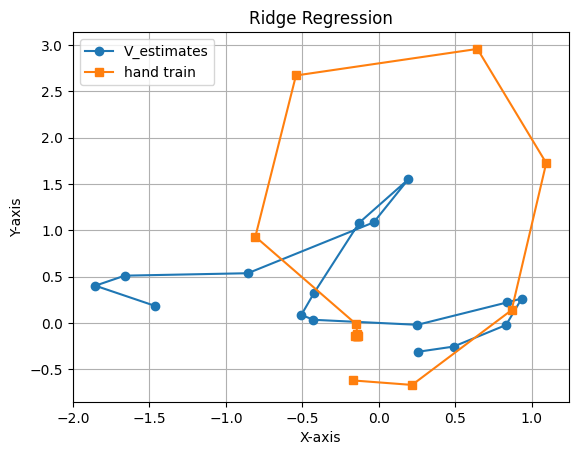

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Number of points (intervals from 0 to 15)
num_points = 16  # This will create 16 points including 0 and 15

# Create x-axis values: evenly spaced intervals from 0 to 15
x = np.linspace(0, 15, num_points)

# Input your own y-values for the two graphs
# Replace these with your own data
a = 80 #cond

print(V_estimates.shape,data["hand_train"].shape)
# First graph y-values
y1 = (V_estimates.reshape(400,2,16))

# Second graph y-values

y2 = (data["hand_train"].transpose(1,0,2))
# Ensure that y1 and y2 have the same length as x
# If necessary, adjust num_points or your y-values accordingly

# Plot the two graphs
plt.plot(y1[a][0], y1[a][1], marker='o', linestyle='-', label='V_estimates')
plt.plot(y2[a][0], y2[a][1], marker='s', label='hand train')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Ridge Regression')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [44]:
#test sendoff
#thats awful i got Your test R2 is: 0.447
import numpy as np
from google.colab import files

# Assuming data and W are already defined
neural_test = data["neural_test"]
neural_test_smooth = np.apply_along_axis(convolve_sequence, axis=-1, arr=neural_test)

neural_test_smooth_reshape = neural_test_smooth.reshape(162,1600)
V_test_estimates_test = (W @ neural_test_smooth_reshape).reshape(2,100,16)

# Save the file
filename = "filename.npy"
np.save(filename, V_test_estimates_test)

# Download the file to the browser
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**-The hand velocity data provided in data["hand_train"] had actually been shifted backward by 120ms relative to the neural data (and similarly for the test set, which was not given to you). Can you speculate about why we did that**

This is probably down to the delay in signal transmition frim the brain to the body. Since there is this delay looking at the hand actions is acctually looking at what the brain told the hand some time ago

**-How does the quality of hand velocity predictions vary with the smoothing window length  σ ? How do you interpret that? You might want to experiment with values between 20 and 80 ms.**

at 20ms the main features are captured but there is a substatial amount of noise

at 80 ms and 50 ms the signal is well smoothed but there are new imaginary features that are not present with the hand some features are smoothed out

at about 35 ms allot of noise is present but more features are captured

i think 50 ms captures the features the best

some major movments are ignoored

**Comment on the suitability of this simple decoding strategy for online (“on the fly”) decoding of movement in a BMI context (consider e.g. feasability, computational tractability, and accuracy). Can you think of a small modification to the above approach that would improve applicability to online decoding? (bonus points for implementing it!**

this is probably quite unsutable as experiments have shown the aaccuracy drops off as soon as this decoder is used without any feedback.




# 3. Kalman filter-based decoding

We now turn to a more sophisticated decoder based on a Kalman filter/smoother.

### 3.1 An autoregressive prior for hand kinematics

A 10-dimensional linear latent dynamical system (“LDS”; cf lecture notes) was pre-trained for you on the hand velocity data in the training set; specifically, we consider the following generative model:

$$
(1) \qquad z_{k, 0} \sim \mathcal{N}(\mu_0, \Sigma_0) \\
(2) \qquad z_{k, t+1} = A z_{k, t} + \epsilon_{k, t+1} \quad \text{with } \epsilon_{k, t+1} \sim \mathcal{N}(0, Q) \\
(3) \qquad v_{k, t} = C z_{k, t} + \eta_{k, t} \quad \text{with } \eta_{k, t} \sim \mathcal{N}(0, R)
$$

where $z_{k, t} \in \mathbb{R}^{10}$ is the latent state in time bin $t$ of trial $k$, and $v_{k, t} \in \mathbb{R}^2$ is the corresponding hand velocity.

The parameters of this LDS can be found in the same `data` dictionary as above, with the following keys:
- "hand_KF_A" (`10 × 10`): state matrix $A$
- "hand_KF_C" (`2 × 10`): output matrix $C$
- "hand_KF_mu0" (`10 × 1`): initial prior mean $\mu_0$
- "hand_KF_Sigma0" (`10 × 10`): initial prior covariance $\Sigma_0$
- "hand_KF_Q" (`10 × 10`): process noise covariance matrix $Q$
- "hand_KF_R" (`2 × 2`): observation noise covariance matrix $R$

<u>Write your own Kalman smoother implementation and use it to compute the mean $\hat{z}_{k, 1:T}$ of the smoothing distribution $p(z_{k, t} | v_{k, 1:T})$, for each trial $k$ in the training set.</u>


$\begin{align*}
p(z_t | v_{1:t}) &= \mathcal{N}(\mu_t, \Sigma_t) \\
\mu_{t+1} &= \Sigma_{t+1} \left[(A \Sigma_t A^\top + BB^\top)^{-1} A \mu_t + C^\top R^{-1} v_{t+1} \right]
\end{align*}$

this seems to be the equasion to do the kalman filtering?? is this the same as smoothing

a slightly diffrent version was found in another set of notes

$\Sigma_{t+1}^{-1} = C^T R^{-1} C + (A \Sigma_t A^T + BB^T)^{-1}$

$\mu_{t+1} = \Sigma_{t+1} \left[ (A \Sigma_t A^T + BB^T)^{-1} A \mu_t + C^T R^{-1} x_{t+1} \right]$

So should $\Sigma$ change? i think yes since there is variation value on value but as you move away from the start there is also variation. hence yes lots of big change

In [9]:
#build a kalman smoothing function
import numpy as np
#stuff
A = data["hand_KF_A"]
C = data["hand_KF_C"]
mu0 = data["hand_KF_mu0"]
Sigma0 = data["hand_KF_Sigma0"]
Q = data["hand_KF_Q"]
R = data["hand_KF_R"]

# something has clearly gone a little wrong the since this is LDS it is not done on an element wise bases but rather a
#for each of the trial k in the training set????
#size is either 2x400x16 or 162x400x16
# inverting to a 10dim dimensional space
# how do you slect x_t+1 perhaps i look at each hand seperatley since their is only 1 per dimension
#Z_hat is not the same as the neuron impulses and is just the neumron stuff

def futureSigma(Last_sigma):
  sigma_t_add_one_inv = C.T@np.linalg.inv(R)@C + np.linalg.inv(A@Last_sigma@A.T + Q)
  return  np.linalg.inv(sigma_t_add_one_inv)

def mu_t_add_one(mu_t,V_add_one, future_sigma):

  adj_ret_data = A@mu_t + future_sigma@C.T@np.linalg.inv(R)@(V_add_one-C@A@mu_t)
  #print(adj_ret_data.shape)
  #ret_data = future_sigma@np.linalg.inv(A@sigma_current@A.T+Q)@A@mu_t+C.T@np.linalg.inv(R)@V_add_one

  return adj_ret_data

def createmu():
    # Reshape hand_train to (400, 2, 16)
    hand_train_reshaped = hand_train.transpose(1, 0, 2)
    neuron_chain = []  # Will hold data for 400 neurons
    neuron_chain_sigma = []

    for n in range(400):
        mu_chain = [mu0]  # Initialize mu_chain with mu0
        sequence_length = hand_train_reshaped.shape[2]  # Should be 16
        sigma_chain = [Sigma0]

        for number in range(sequence_length - 1):
            # Get data from both hands for neuron n at time number + 1
            dataLocal = np.matrix(hand_train_reshaped[n, :, number + 1]).T
            future_Sigma = futureSigma(sigma_chain[-1])

            # Compute mu_t_add_one using data from both hands
            mu_t = mu_t_add_one(
                mu_chain[-1],
                dataLocal,
                future_Sigma
            )
            mu_chain.append(mu_t)
            sigma_chain.append(future_Sigma)


        # Convert mu_chain to a numpy array of shape (16, 10)

        mu_chain_array = np.array(mu_chain).T[0]
        neuron_chain.append(mu_chain_array)

        sigma_chain_array = np.array(sigma_chain)
        neuron_chain_sigma.append(sigma_chain_array)

    # Convert neuron_chain to a numpy array of shape (400, 16, 10)
    neuron_chain_array = np.array(neuron_chain)

    neuron_sigma_chain_array = np.array(neuron_chain_sigma)

    # go to shape (400, 10, 16)
    neuron_chain_array = neuron_chain_array.transpose(0, 2, 1)
    #neuron_sigma_chain_array = neuron_sigma_chain_array.transpose(0, 2, 1)

    return neuron_chain_array, neuron_sigma_chain_array

filtered_neuro_train, associatedSigma = createmu()

print(filtered_neuro_train.shape)

print(associatedSigma.shape)

#TODO: i think my sigma update step is correct where i simply add the process noise to the sigma error

(400, 16, 10)
(400, 16, 10, 10)


$G_t \equiv \Sigma_t A^T (A \Sigma_t A^T + B B^T)^{-1}$

$\tilde{\mu}_t = \mu_t + G_t (\tilde{\mu}_{t+1} - A \mu_t)$

$\tilde{\Sigma}_t = \Sigma_t + G_t (\tilde{\Sigma}_{t+1} - P_t) G_t^T$

this set of equasions was found in the extension notes for section 4 and indicates the backwards propigation needed to complete the smoothing process

In [10]:
#this function will back propigate through the function
#step 1 make a set of 16 G_t to use
#step 2 back propigate to get mu_t
#step 3 back propigate to get sigma_t

#step1
sigma_relevant = associatedSigma[0]

def gen_G_t():
  time_step_stor = []
  sig = [Sigma0]
  for step in range(16):
    futsig= A@sig[-1]@A.T + Q
    G_t = sig[-1]@A.T@np.linalg.inv(futsig)
    time_step_stor.append(G_t)
    sig.append(futsig)
  return np.array(time_step_stor)

G_t = gen_G_t()
print(G_t.shape)
#step 2

def mu_mean_smooth(filtered_neuro_train,A,G_t):

  top_store = []

  for cond in filtered_neuro_train:
    mu_hat_store = [cond[-1]]

    for timeStep in range(len(cond)-1,0,-1):
      mu = cond[timeStep]
      mu_add_one_hat = mu_hat_store[0]
      mu_hat = mu + G_t[timeStep]@(mu_add_one_hat-A@mu) # this shouldnt do anything ???/
      mu_hat_store.insert(0,mu_hat)

    top_store.append(mu_hat_store)

  return np.array(top_store)

mu_mean_pzv = mu_mean_smooth(filtered_neuro_train,A,G_t)

print(mu_mean_pzv.shape)

# step 3 needs to be done

(16, 10, 10)
(400, 16, 10)


In [11]:
#stage 3

# Assuming that:
# Sigma has shape (400, 16, 10, 10)
# G has shape (16, 10, 10) [the same G_t for all conditions, varying by time step]
# A has shape (10, 10)
# The terminal condition is that tilde_Sigma at the last time step t=15 (0-based index) is equal to Sigma at t=15.

def backprop_tilde_Sigma(Sigma, G, A):
    # Extract dimensions
    num_conditions, num_timesteps, m, n = Sigma.shape
    assert m == n == 10, "Sigma matrices must be 10x10."
    assert G.shape == (num_timesteps, 10, 10), "G must be of shape (16,10,10)."
    assert A.shape == (10, 10), "A must be 10x10."

    # Initialize tilde_Sigma with the same shape as Sigma
    tilde_Sigma = np.zeros_like(Sigma)

    # For each condition, we perform the backpropagation
    for cond in range(num_conditions):
        # Set terminal condition:
        # tilde_Sigma_{T-1} = Sigma_{T-1}, where T=16, so T-1=15 (0-based indexing)
        tilde_Sigma[cond, -1] = Sigma[cond, -1]

        # Backpropagate from t=14 down to t=0
        for t in reversed(range(num_timesteps - 1)):
            # Compute P_t = A * Sigma_t * A^T
            P_t = A @ Sigma[cond, t] @ A.T + Q

            # Compute tilde_Sigma_t
            # tilde_Sigma_t = Sigma_t + G_t (tilde_Sigma_{t+1} - P_t) G_t^T
            tilde_Sigma[cond, t] = Sigma[cond, t] + G[t] @ (tilde_Sigma[cond, t+1] - P_t) @ G[t].T

    return tilde_Sigma

tilde_Sigma_PZV = backprop_tilde_Sigma(associatedSigma,G_t,A)
print(tilde_Sigma_PZV.shape)


(400, 16, 10, 10)


ValueError: 'p' is not a valid value for color

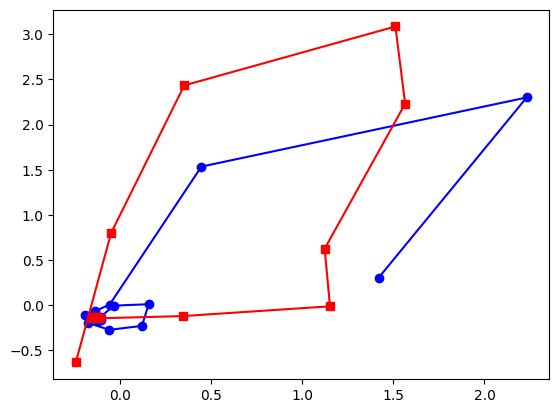

In [12]:
#i need some sort of comparrison to prove things are getting better

condition = 356

def kalmanFilterEq(x_data):
  T = 16
  mu = mu0.reshape(10)
  Sigma = Sigma0
  z_outputs = []
  R_inv = np.linalg.inv(R)

  for t in range(T):
      S = A @ Sigma @ A.T + Q
      Sigma_inv_new = C.T @ R_inv @ C + np.linalg.inv(S)
      Sigma_new = np.linalg.inv(Sigma_inv_new)
      mu_new = A@mu + Sigma_new@C.T@R_inv@(x_data[t]-C@A@mu)#Sigma_new @ (np.linalg.inv(S) @ A @ mu + C.T @ R_inv @ x_data[t])
      z_outputs.append(mu_new)
      mu, Sigma = mu_new, Sigma_new

  z_outputs = np.array(z_outputs)
  return z_outputs



kalfilt = kalmanFilterEq(hand_train.reshape(400,16,2)[condition])

def conBACK(kalkalfilt):
  datacheck = kalfilt #smooth_data[condition]
  result2 = np.empty((2,16))
  for i in range(len(datacheck)):
    datacheckchecked = C@datacheck[i].T
    result2[0,i] = datacheckchecked[0]
    result2[1,i] = datacheckchecked[1]
  return result2


filtered_neuro_train = filtered_neuro_train.reshape(400,16,10)
x0 = conBACK(filtered_neuro_train[condition])
x1 = conBACK(kalfilt)
x2 = hand_train.reshape(400,2,16)[condition]



# Plot both data sets on the same figure
plt.plot(x1[0], x1[1], label='vxmu', color='blue', marker='o')
plt.plot(x2[0], x2[1], label='train', color='red', marker='s')
plt.plot(x0[0], x0[1], label='this', color='p', marker='s')


# Highlight the starting node with a different shape (e.g., a star marker)
plt.plot(x1[0][0], x1[1][0], marker='*', markersize=15, color='purple', label='Starting Node')
plt.plot(x2[0][0], x2[1][0], marker='*', markersize=15, color='orange', label='Starting Node')

# Add title, labels, and legend
plt.title('Comparison of Two Data Sets')
plt.xlabel('X-values')
plt.ylabel('Y-values')
plt.legend()

# Optionally, add a grid
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
if allah:
  break

### 3.2 Building an LDS model of neural data using supervised learning

Conceptually, the latents $z_{k, 1:T}$ introduced above contain signals related to the velocity of the hand, its acceleration, and potentially higher-order derivatives too — all signals which we have good reasons to suspect that neural activity in M1 is strongly related to. Eqs (1) and (2) above provide a good autoregressive prior model for the temporal dynamics of these signals, and you are now going to use this prior in a generative LDS model of _neural data_, substituting the hand-related likelihood (Eq 3) with a neural likelihood:

$$
(4) \qquad x_{k, t} = D z_{k, t} + \xi_{k, t} \quad \text{with } \xi_{k, t} \sim \mathcal{N}(0, S)
$$

where $x_{k, t}$ denotes neural spike counts in the $t^\text{th}$ time bin of trial $k$.

The combination of Eqs (1), (2) and (4) forms an LDS model which you will be able to invert using Kalman filtering to obtain a filtered posterior $p(z_{k', t} | x_{k', 0:t})$ for any test trial $k'$. From there, you will use Eq. (3) to obtain a filtered predictive distribution for the hand velocity in each test trial, $p(v_{k', t} | x_{k', 0:t})$.

- <u>Begin by centering the neural data (both training and testing sets) by removing, for each neuron, its mean activity across both trials and time in the training set.</u>
- <u>Fit the likelihood parameters $D$ and $S$ through supervised learning, by maximizing the joint log-likelihood $\log p(\hat{z}_{k, 1:T}, x_{k, 1:T})$ averaged over all trials in the training set, where $\hat{z}_{k,1:T}$ is the posterior mean you obtained in Section 3.1.</u>
To do this, write down the average joint log likelihood and **show that it is maximized by the following parameter settings, include derivations in the report**:

$
\displaystyle D^\star = \left( \sum_{k, t} x_{k, t} \left( \hat{z}_{k, t} \right)^\top \right) \left( \sum_{k, t} \hat{z}_{k, t} \left( \hat{z}_{k, t} \right)^\top \right)^{-1}
$
$
\displaystyle S^\star = \frac{1}{K T} \left( \sum_{k, t} x_{k, t} \left( x_{k, t} \right)^\top - D^\star \left( \sum_{k, t} \hat{z}_{k, t} \left( x_{k, t} \right)^\top \right) \right)
$


    - $ \displaystyle D^\star = \left(\sum_{k, t} x_{k, t} \hat{z}_{k, t}^\top \right) \left( \sum_{k, t} \hat{z}_{k, t} \hat{z}_{k, t}^\top \right)^{-1} $
    - $ \displaystyle S^\star = \frac{1}{KT} \left( \sum_{k, t} x_{k, t} x_{k, t}^\top - D^\star \sum_{k, t} \hat{z}_{k, t} x_{k, t}^\top \right) $ where $K$ is the number of trials in the training set. **Include your derivations in your report.**

In [ ]:
#centering neural data K is number of trials and T is total time
neural_train_centered = neural_train - neural_train.mean(axis = (1,2), keepdims = True) #np.mean(neural_train)

neural_test = neural_test.reshape(162,100,16)
neural_test_centered = neural_test - neural_test.mean(axis = (1,2), keepdims = True)

CON_NUM = 400
TIME_BINS = 16
TIME_BIN_WIDTH = 50
#get D
z_hat = filtered_neuro_train # mu_mean_pzv
#z_hat = filtered_neuro_train - filtered_neuro_train.mean(axis = (1,2), keepdims = True)
x = neural_train_centered
#reformat
x = x.transpose(1,2,0)
z_hat = z_hat.reshape(400*16,10).T    #this may need to change for the the trial case
x = x.reshape(400*16,162).T

D_Star = x@z_hat.T@np.linalg.inv(z_hat@z_hat.T)
S_Star = 1/(CON_NUM*TIME_BINS*TIME_BIN_WIDTH) * (x@x.T - D_Star@z_hat@x.T)


MATCHECK = z_hat@z_hat.T
print(np.array_equal(MATCHECK,MATCHECK.T))


'''R = x@x.T - D_Star @ z_hat @ x.T  # (162,6400)
S_Star = (R @ R.T) / (CON_NUM * TIME_BINS)'''



In [ ]:

#make a kalman filter to obtain p(z|x)
#format variables
x = neural_train

# continue to use same mu0 and Sigma0

def futureSigma(Last_sigma):
  sigma_t_add_one_inv = D_Star.T@np.linalg.inv(S_Star)@D_Star + np.linalg.inv(A@Last_sigma@A.T + Q)
  # error S_Star is not a valid covarience matrix
  return np.linalg.inv(sigma_t_add_one_inv)

def mu_t_add_one(mu_t,x_add_one, future_sigma):

  adj_ret_data =  A@mu_t +future_sigma@D_Star.T@np.linalg.inv(S_Star)@(x_add_one-D_Star@A@mu_t)
  return adj_ret_data

def createmu(x=x,countForn = 400):
    # Reshape from 162,400,16 to (400, 162, 16)
    x_reshaped = x.transpose(1, 0, 2)
    cond_chain = []  # Will hold data for 400 cond
    cond_chain_sigma = []

    for n in range(countForn):
        mu_chain = [mu0]  # Initialize mu_chain with mu0
        sequence_length = x.shape[2]  # Should be 16
        sigma_chain = [Sigma0]

        for number in range(sequence_length - 1):
            # Get data from both hands for neuron n at time number + 1
            dataLocal_add_x = np.matrix(x_reshaped[n, :, number + 1]).T
            future_Sigma = futureSigma(sigma_chain[-1])

            # Compute mu_t_add_one using data from both hands
            mu_t = mu_t_add_one(
                mu_chain[-1],
                dataLocal_add_x,
                future_Sigma
            )


            mu_chain.append(mu_t)
            sigma_chain.append(future_Sigma)


        # Convert mu_chain to a numpy array of shape (16, 162)

        mu_chain_array = np.array(mu_chain).T[0]

        cond_chain.append(mu_chain_array)

        sigma_chain_array = np.array(sigma_chain)
        cond_chain_sigma.append(sigma_chain_array)

    # Convert neuron_chain to a numpy array of shape (400, 16, 162)
    neuron_chain_array = np.array(cond_chain)

    neuron_sigma_chain_array = np.array(cond_chain_sigma)

    # go to shape (400, 162, 16)
    neuron_chain_array = neuron_chain_array.transpose(0, 2, 1)
    #neuron_sigma_chain_array = neuron_sigma_chain_array.transpose(0, 2, 1)

    return neuron_chain_array, neuron_sigma_chain_array

PZgivenX =createmu()[0]
PZgivenX_sigma = createmu()[1]
print(PZgivenX.shape)
print(PZgivenX_sigma.shape )




In [ ]:
#first gather the probabilities P(z|x)


result_vxMu = np.empty((400,2,16))
result_vxSigma = np.empty((400,16,2,2))
for i in range(400):
    A_PZX = PZgivenX[i,:,:]  # (16,10)
    result_vxMu[i,:,:] = C @ A_PZX.T


print(result_vxMu.shape)




In [ ]:
print(result_vxMu.shape)
print(hand_train.shape)
print(PZgivenX.shape)

In [ ]:

condition = 90

x1 = result_vxMu[condition]
x2 = hand_train.reshape(400,2,16)[condition]


# Plot both data sets on the same figure
plt.plot(x1[0], x1[1], label='vxmu', color='blue', marker='o')
plt.plot(x2[0], x2[1], label='train', color='red', marker='s')
plt.plot(y1[condition][0], y1[condition][1], label='linear reg', color='orange', marker='p')
# Add title, labels, and legend
plt.title('Comparison of Two Data Sets')
plt.xlabel('X-values')
plt.ylabel('Y-values')
plt.legend()

# Optionally, add a grid
plt.grid(True)

# Display the plot
plt.show()

### 3.3 Using Kalman filtering to predict the hand velocity

- Based on the model obtained in Section 3.2, <u>write your own Kalman filter implementation and compute the filtered posterior $p(z_{k', t} | x_{k', 0:t}) $ for each trial $k'$ in the test set.</u> What we are really interested in is the mean $\bar{z}_{k', t}$ of this filtered posterior, as our best prediction of the momentary hand velocity $v_{k', t}$ is then given by $\hat{v}_{k', t} = C \bar{z}_{k', t}$.
- <u>Submit your predictions to http://4G10.cbl-cambridge.org (note: http, not https) in the same format as described in Section 2. Please select "Kalman filtering" in the dropdown list. Once again, you will receive immediate feedback in the form of an $R^2$ coefficient.</u> **Include this result in your report, and discuss; in particular, why do you think these predictions are much better than those of Section 2?**
- As in Section 2, **comment on the suitability of this more sophisticated decoding strategy for online decoding of movement in a BCI context**.
- Finally, **what approach(es) would you suggest to improve decoding performance even further? Include a discussion of the tradeoffs that would arise with these alternative approaches.** (max 1 page in your report)

In [ ]:
#P(z|x) test

neural_test_centered_x = neural_test_centered.reshape(162,100,16)

test_mu, test_sig = createmu(x=neural_test_centered_x,countForn = 100)

result_vxMu_test = np.empty((100,2,16))

for i in range(100):
    A_test = test_mu[i,:,:]  # (16,10)
    result_vxMu_test[i,:,:] = C @ A_test.T




In [ ]:
#test sendoff
#Your test R2 is: -2.287 this was orginal
# new -0.77 new update to put process noise Q in the update to sigma
import numpy as np
from google.colab import files

# Assuming data and W are already defined

my_array = result_vxMu_test.reshape(2,100,16)
print(my_array.shape)
my_array.astype("float64")
# Save the file
filename = "filename.npy"
np.save(filename, my_array)

# Download the file to the browser
#files.download(filename)

  # Writing up


Please write up your findings in a report to be submitted on Moodle in PDF format, and **include all your code in the Appendix**. Please clearly include your candidate number, NOT your name, on the front page. Your report should address all the questions raised in this notebook, be structured around the Sections of this notebook, and **be a maximum of five A4 pages** excluding any Appendix (minimum font size 11pt, minimum margins 1.5cm on each side).

You are very much encouraged to think of data/results visualisations to best support the exposition of your results. You are also encouraged to report on any specific problems/difficulties that arose in your implementation of the various algorithms, and how you addressed those.